# Predicting Sales Prices

 ## Dataset Attributes

 The dataset contains information about houses in Ames, Iowa. The data was collected by the Ames City Assessor’s Office describing 2930 property sales which occurred in Ames, Iowa between 2006 and 2010. The dataset, containing 81 variables, was compiled and published by De Cock in 2011.

 Some of the variables contained in the original dataset have been removed from the the dataset provided to you.
 The dataset provided to you contains the following variables:
* **Year_Built:** year that the house was originally constructed
* **Year_Remod_Add:** year that the house was last remodelled
* **Total_Bsmt_SF:** total size of basement area in square feet
* **First_Flr_SF:** size of the first floor in square feet
* **Second_Flr_SF:** size of the second floor in square feet
* **Gr_Liv_Area:** size of above grade, ground living area in square feet
* **Full_Bath:** number of full above grade bathrooms in the house
* **Half_Bath:** number of half above grade bathrooms in the house
* **Bedroom_AbvGr:** number of above grade bedrooms (does not include basement bedrooms)
* **Kitchen_AbvGr:** number of above grade kitchens
* **TotRms_AbvGrd:** total number of above grade rooms (does not include bathrooms)
* **Fireplaces:** number of fireplaces in the house
* **Garage_Area:** size of garage in square feet
* **Sale_Price:** sale price of the house in dollars


*De Cock, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester
Regression Project," Journal of Statistics Education, Volume 19, Number 3.*

- https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
- http://ww2.amstat.org/publications/jse/v19n3/decock.pdf


 ## Objective

 The goal of this task is to analyse the relationship between these variables and build a multiple linear regression model to predict the sales prices based on the 'Gr_Liv_Area' and 'Garage_Area` variables.


In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:


def evaluate_model(Y_test, predictions, feature_names, coefficients):

    """
    Evaluate a regression model's performance and interpret its coefficients.

    Prints RMSE, MSE, R² score, and explains feature impact on predicted sale price.

    Parameters:
        Y_test: True target values.
        predictions: Model's predicted values.
        feature_names: Names of input features.
        coefficients: Model coefficients.

    Returns:
        R² score of the model.
    """

    from sklearn.metrics import mean_squared_error, r2_score

    # Compute RMSE and error %
    mse = mean_squared_error(Y_test, predictions)
    rmse = np.sqrt(mse)
    median_price = np.median(Y_test)
    mean_price = np.mean(Y_test)

    print(f"Median Sale Price: ${median_price:.2f}")
    print(f"Mean Sale Price: ${mean_price:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

    rmse_pct = (rmse / median_price * 100) if median_price else 0
    rmse_pct_str = f"{rmse_pct:.2f}%" if median_price else "N/A (median price is zero)"
    print(f"RMSE as % of Median Price: {rmse_pct_str}\n")

    # Coefficient analysis
    print("Feature coefficient analysis:")
    for feature, coef in zip(feature_names, coefficients):
        percent_increase = (coef / median_price * 100) if median_price else 0
        print(f"\n{feature}: {coef:.3f}")
        print(f"A one standard deviation increase in {feature} "
              f"leads to an average increase of approximately ${coef:.2f} "
              "in predicted sale price.\n"
              f"Given that the median home price is ${median_price:.2f}, "
              f"this represents a {percent_increase:.1f}% increase relative to a typical home.")

    # Compute R²
    r2 = r2_score(Y_test, predictions)
    print(f"\nR² Score: {r2:.4f}")
    print(
        f"This indicates that approximately {r2 * 100:.1f}% "
        "of the variance in sales prices is explained by the model."
    )
    print(
        f"The typical prediction error is ${rmse:.2f}, "
        f"which amounts to {rmse_pct_str} of the median home price."
    )

    return r2


def training_set(X, Y):

    """
    Split data into training and test sets, then standardize the features.

    Parameters:
        X: Feature matrix.
        Y: Target values.

    Returns:
        Standardized X_train, X_test, Y_train, Y_test, and fitted StandardScaler.
    """

    # Split into train and test sets
    rseed = 0
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=rseed)

    print("Training data:", X_train.shape, Y_train.shape)
    print("Test data:", X_test.shape, Y_test.shape)

    # Standardize features
    sc = StandardScaler()
    sc.fit(X_train)

    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # Return everything needed downstream
    return X_train, X_test, Y_train, Y_test, sc


def linear_regression(X_train, X_test, Y_train, feature_list):
    """
    Fit a linear regression model, print its parameters, and return predictions.

    Prints the intercept, coefficients, and full regression equation.

    Returns:
        Trained LinearRegression model and its predictions on the test set.
    """

    lm = LinearRegression()
    model = lm.fit(X_train, Y_train)
    predictions = lm.predict(X_test)


    print('Intercept: \n', lm.intercept_)
    print('Coefficients: \n', lm.coef_)

    regression_equation = f"Y = {lm.intercept_[0]:.3f}"

    for feature, coef in zip(feature_list, lm.coef_[0]):
        regression_equation += f" + ({coef:.3f} * {feature})"

    print("\nThis provides a regression equation of: ")
    print(regression_equation)

    return lm, predictions


def make_predictions(lm, sc, X_test, feature_list, n=5):
    """
    Generate predictions and return a readable DataFrame of test results.

    Returns the first 5 rows of the original (unscaled) test features along with
    their predicted sale prices.
    """

    # Use model to predict Y using test set
    Y_pred = lm.predict(X_test)

    # Reverse standardization for benefit of visualization
    X_test_original = sc.inverse_transform(X_test)

    # Create a DataFrame for readability
    pred_df = pd.DataFrame(X_test_original[0:n], columns=feature_list)
    pred_df['Predicted_Sale_Price'] = Y_pred[0:n]

    return pred_df


def plot_error_bars(df, Y_test, predictions, X_test, feature_list, n_rows, n_cols):

    """
    Plot true vs. predicted sale prices with error bars for each feature.

    Displays subplots with standardized feature values on the x-axis, actual prices with error bars,
    and predicted prices for comparison.
    """

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 12), sharex=True, sharey=True)

    ax = ax.flatten()  # Flatten for easy indexing
    fig.suptitle("True vs Predicted Sale Price with Error Bars")
    ax[0].set_ylabel("Sale Price ($ millions)")

    # Get values for the error bar
    error_bar_values = np.abs((Y_test-predictions)[:,0])

    # Plot data, predicted values, and error bars
    for i in range(X_test.shape[1]):
        ax[i].errorbar(X_test[:, i], Y_test[:, 0], yerr=error_bar_values, fmt='.k', ecolor='red', label='True')
        ax[i].scatter(X_test[:,i], predictions[:,0], c='b', marker='.', label='Predicted')
        ax[i].legend(loc='best', fontsize='small')
        ax[i].set_xlabel(f"{feature_list[i]} (standardized)")


In [4]:
# Read in the data set
ames_df = pd.read_csv("ames.csv")

ames_df.head()

,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
0,1960,1960,1080,1656,0,1656,1,0,3,1,7,2,528,215000
1,1961,1961,882,896,0,896,1,0,2,1,5,0,730,105000
2,1958,1958,1329,1329,0,1329,1,1,3,1,6,0,312,172000
3,1968,1968,2110,2110,0,2110,2,1,3,1,8,2,522,244000
4,1997,1998,928,928,701,1629,2,1,3,1,6,1,482,189900


In [5]:
# Clean and pre-process the data if neccessary
ames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year_Built      2930 non-null   int64
 1   Year_Remod_Add  2930 non-null   int64
 2   Total_Bsmt_SF   2930 non-null   int64
 3   First_Flr_SF    2930 non-null   int64
 4   Second_Flr_SF   2930 non-null   int64
 5   Gr_Liv_Area     2930 non-null   int64
 6   Full_Bath       2930 non-null   int64
 7   Half_Bath       2930 non-null   int64
 8   Bedroom_AbvGr   2930 non-null   int64
 9   Kitchen_AbvGr   2930 non-null   int64
 10  TotRms_AbvGrd   2930 non-null   int64
 11  Fireplaces      2930 non-null   int64
 12  Garage_Area     2930 non-null   int64
 13  Sale_Price      2930 non-null   int64
dtypes: int64(14)
memory usage: 320.6 KB


Since all the columns are complete and the correct data type is present in each column. No cleaning or pre-processing is required.

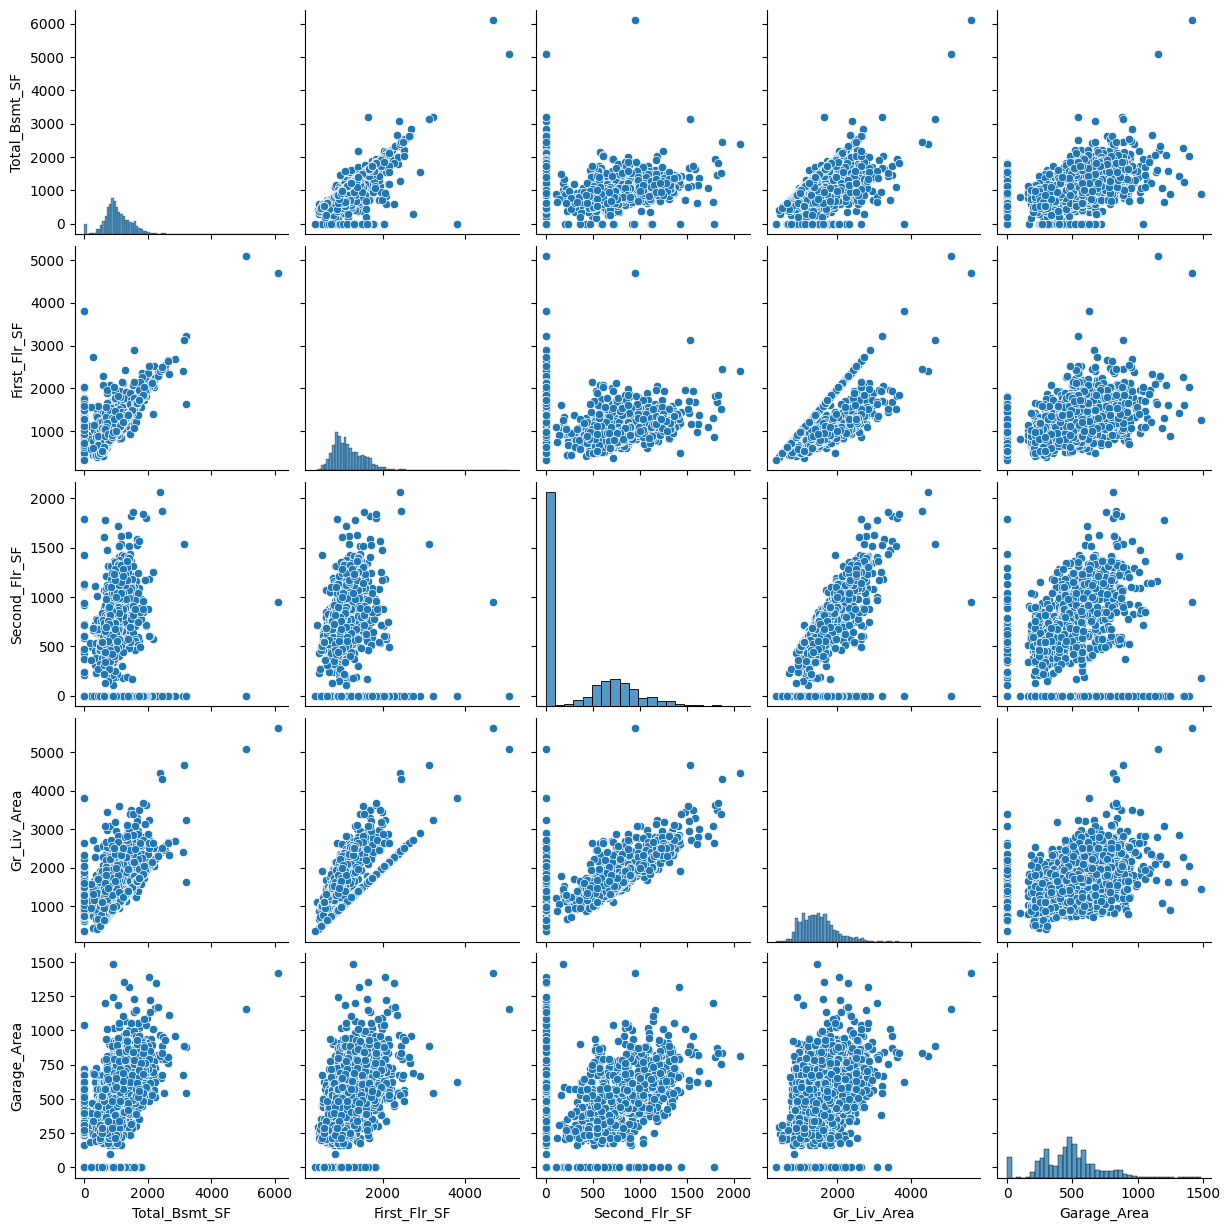

In [6]:
# Explore the data with visualisations such as histograms and correlation matrices

# Select all independent variables that are less discrete in nature.
selected_cols = [
    "Total_Bsmt_SF",
    "First_Flr_SF",
    "Second_Flr_SF",
    "Gr_Liv_Area",
    "Garage_Area"
]

sns.pairplot(data = ames_df[selected_cols])


##### Most features are approximately Gaussian with some outliers. Standardization is preferred over normalization as it centers the data around the mean and is less sensitive to outliers compared to Min-Max scaling, which compresses the range and can be heavily influenced by extreme values

In [7]:
# Split the independent variables from the dependent variable

# First use all X (independent variables) to visualize entire dataset

# Get independent variable names
feature_names = ames_df.columns[0:13]

# Assign X to first 10 columns (independent variables)
X = ames_df.iloc[:,0:13].values

# Assign Y to last column (dependent variables)
Y = ames_df.iloc[:,-1].values

# Confirm X and Y variables
Y = Y.reshape(-1, 1)
print(f"Shape of Y (dependent variable) is {Y.shape}")

X = X.reshape(-1, X.shape[1])
print(f"Shape of X (independent variables) is {X.shape}")

print("\nX independent variables are:\n")
for feature in feature_names:
    print(feature)

Shape of Y (dependent variable) is (2930, 1)
Shape of X (independent variables) is (2930, 13)

X independent variables are:

Year_Built
Year_Remod_Add
Total_Bsmt_SF
First_Flr_SF
Second_Flr_SF
Gr_Liv_Area
Full_Bath
Half_Bath
Bedroom_AbvGr
Kitchen_AbvGr
TotRms_AbvGrd
Fireplaces
Garage_Area


Top 4 correlated features:
Gr_Liv_Area      0.706780
Garage_Area      0.640138
Total_Bsmt_SF    0.632529
First_Flr_SF     0.621676
Name: Sale_Price, dtype: float64


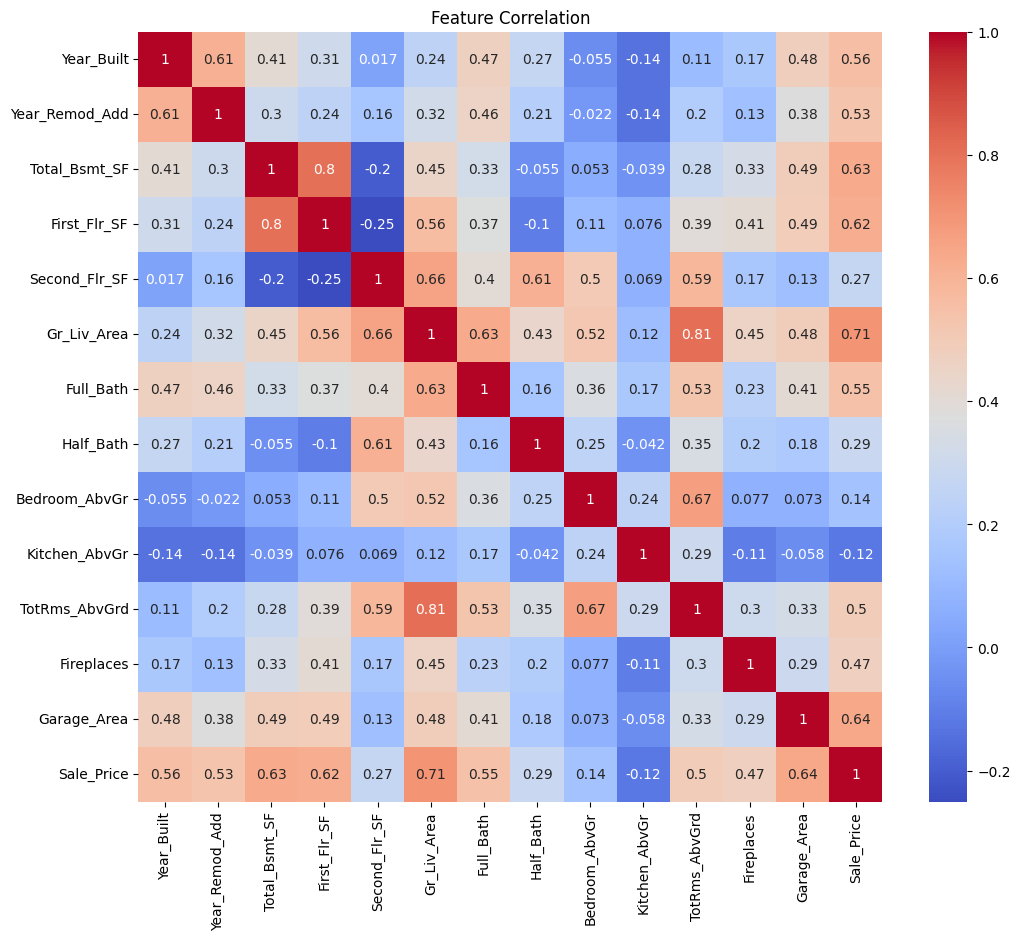

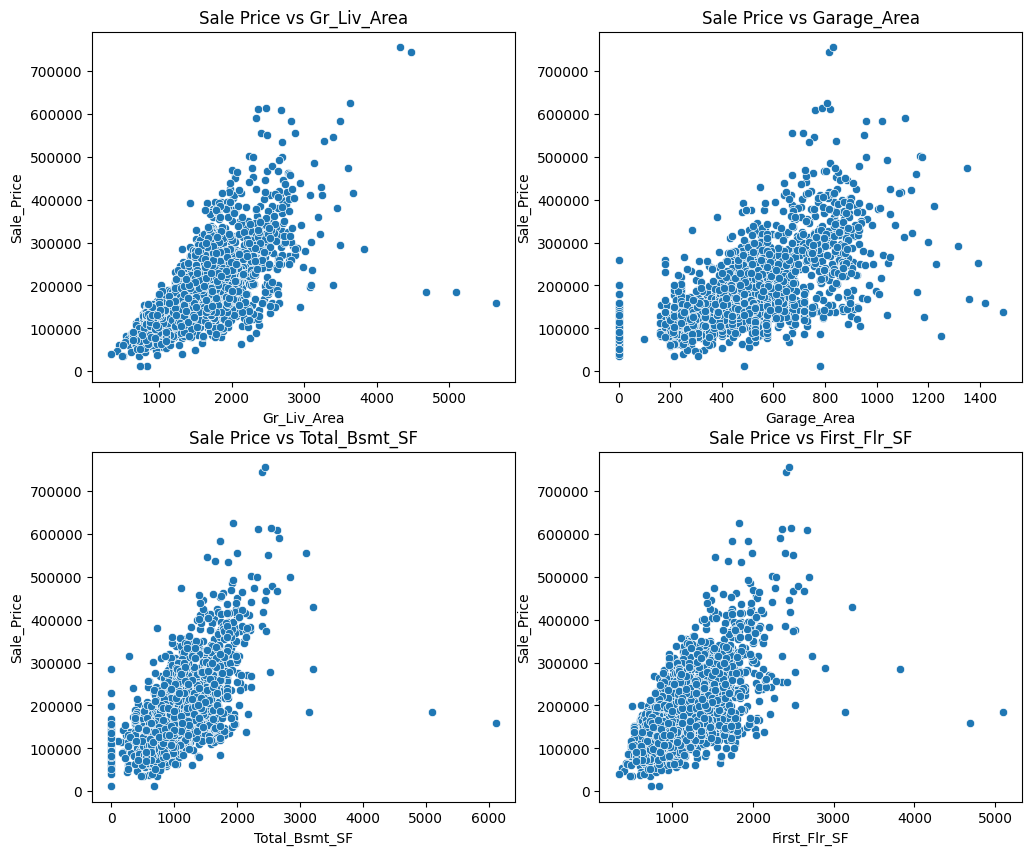

In [8]:
# Explore relationships between the independent and dependent variables

# Compute correlation matrix (identify X value with highest correlation)
corr_matrix = ames_df.corr(numeric_only=True)

# Get absolute correlation with 'Sale_Price' and sort
top_features = corr_matrix['Sale_Price'].drop('Sale_Price').abs().sort_values(ascending=False).head(4)

print("Top 4 correlated features:")
print(top_features)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, feature in zip(axes.flatten(), top_features.index):
    sns.scatterplot(x=ames_df[feature], y=ames_df["Sale_Price"], ax=ax)
    ax.set_title(f'Sale Price vs {feature}')
plt.show()

In [9]:
# Redefine X based on correlation values

top_2_features = top_features.head(2).index
X = ames_df[top_2_features].values

print(f"Top 2 features used for X: {list(top_2_features)}")

X_train, X_test, Y_train, Y_test, sc = training_set(X, Y)


Top 2 features used for X: ['Gr_Liv_Area', 'Garage_Area']
Training data: (2197, 2) (2197, 1)
Test data: (733, 2) (733, 1)


In [10]:
lm, predictions = linear_regression(X_train, X_test, Y_train, top_2_features)

Intercept: 
 [180577.2243969]
Coefficients: 
 [[41408.82081703 30551.84073447]]

This provides a regression equation of: 
Y = 180577.224 + (41408.821 * Gr_Liv_Area) + (30551.841 * Garage_Area)


In [11]:
make_predictions(lm, sc, X_test, top_2_features)

,Gr_Liv_Area,Garage_Area,Predicted_Sale_Price
0,1991.0,432.0,217101.891886
1,990.0,440.0,133751.654988
2,1970.0,753.0,260591.581974
3,1134.0,254.0,119677.814822
4,1178.0,384.0,141721.534279


In [12]:
evaluate_model(Y_test, predictions, top_2_features, lm.coef_[0])


Median Sale Price: $162500.00
Mean Sale Price: $181451.97
Mean Squared Error (MSE): 2351014153.80
Root Mean Squared Error (RMSE): $48487.26
RMSE as % of Median Price: 29.84%

Feature coefficient analysis:

Gr_Liv_Area: 41408.821
A one standard deviation increase in Gr_Liv_Area leads to an average increase of approximately $41408.82 in predicted sale price.
Given that the median home price is $162500.00, this represents a 25.5% increase relative to a typical home.

Garage_Area: 30551.841
A one standard deviation increase in Garage_Area leads to an average increase of approximately $30551.84 in predicted sale price.
Given that the median home price is $162500.00, this represents a 18.8% increase relative to a typical home.

R² Score: 0.6393
This indicates that approximately 63.9% of the variance in sales prices is explained by the model.
The typical prediction error is $48487.26, which amounts to 29.84% of the median home price.


0.639284589444093

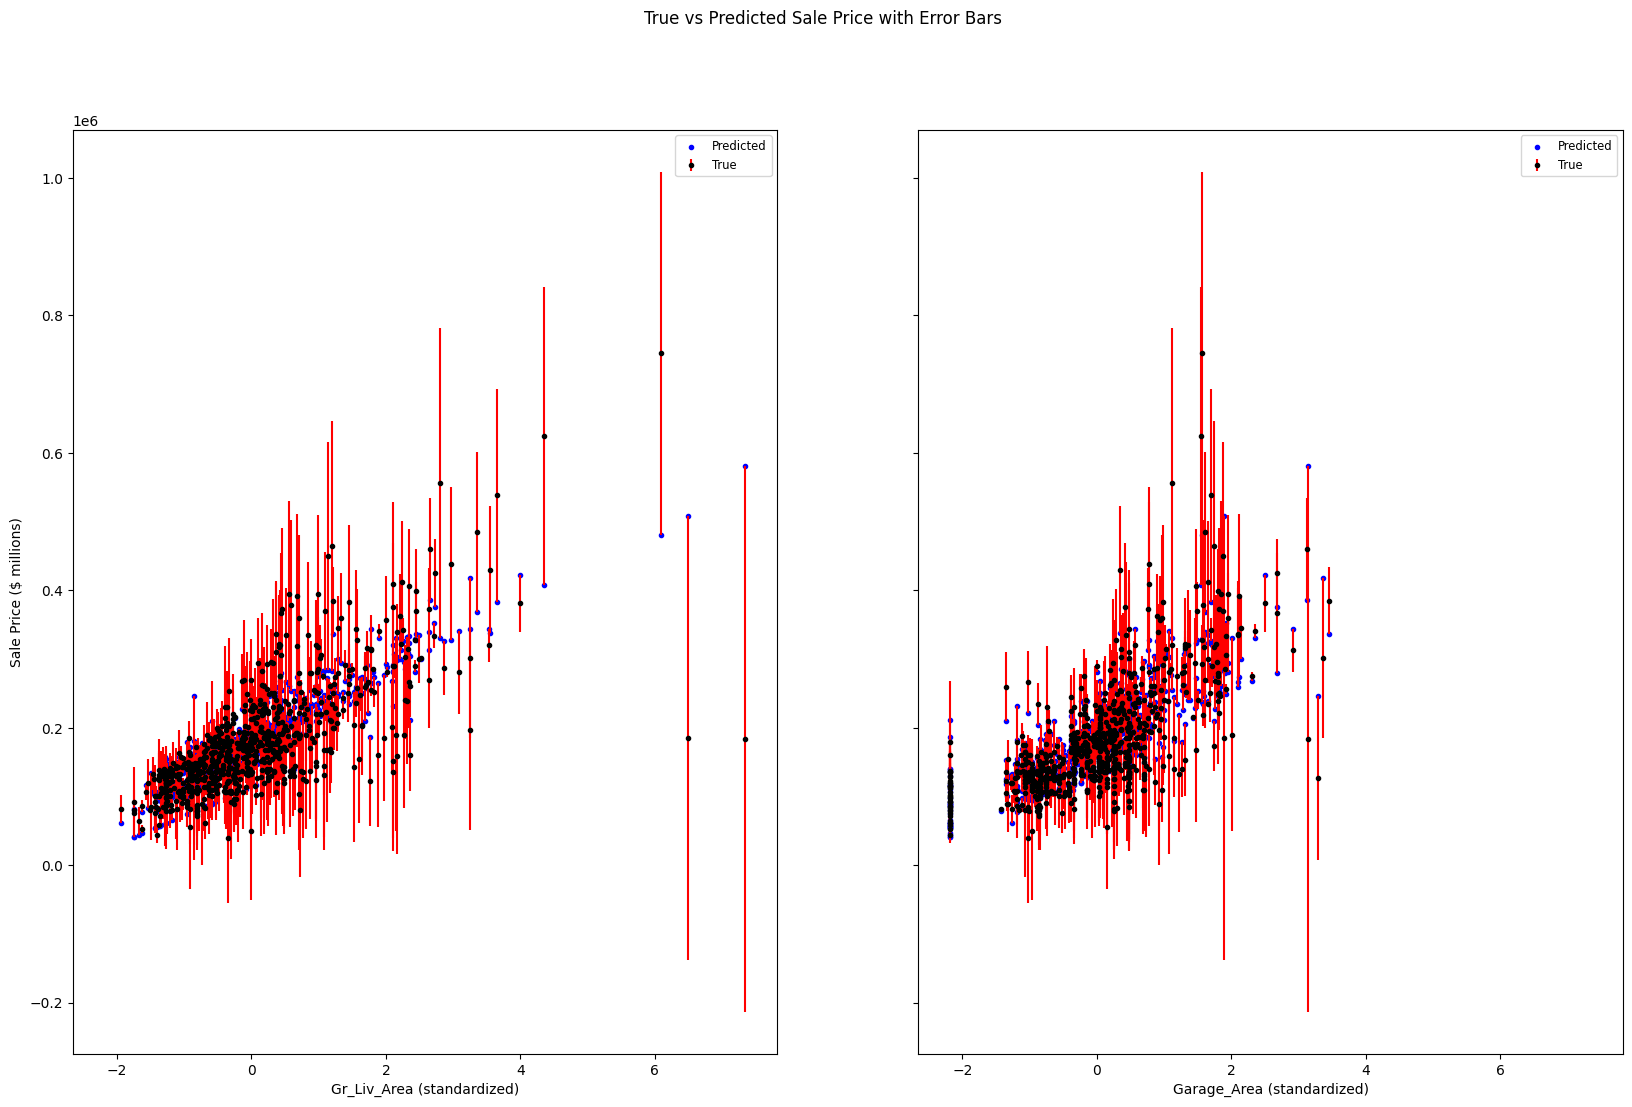

In [13]:
plot_error_bars(ames_df, Y_test, predictions, X_test, top_2_features,1,2)

**Summarise findings**

The linear regression model demonstrates a moderate ability to explain variation in house sale prices, with an R² of 0.639, indicating that approximately 64% of the variance in sale prices is captured by the model. The typical prediction error is given as $48,487, which equates to roughly 30% of the median home price — a substantial margin given the median house price is $162,500.

Among the predictors used, both ground living area (Gr_Liv_Area) and garage area (Garage_Area) show strong positive associations with sale price. Specifically, a one standard deviation increase in Gr_Liv_Area corresponds to a $41,409 increase in predicted price (about 25.5% of the median price), while a similar increase in Garage_Area adds roughly $30,552 (or 18.8% of the median price).

The error bars on the scatter plots increase with size, suggesting that the model becomes less reliable as Gr_Liv_Area and Garage_Area increase. Additionally, the relationship between Garage_Area and sale price appears less linear, indicating that other unaccounted-for features may influence this relationship.

While the model effectively captures key variables that affect sale prices, the level of error suggests there is room for improvement, potentially by incorporating additional features.

## Recreate model using top 4 features

In [14]:
# Redefine X based on correlation values

top_4_features = top_features.head(4).index
X = ames_df[top_4_features].values

print(f"Top 4 features used for X: {list(top_4_features)}")

X_train, X_test, Y_train, Y_test, sc = training_set(X,Y)

Top 4 features used for X: ['Gr_Liv_Area', 'Garage_Area', 'Total_Bsmt_SF', 'First_Flr_SF']
Training data: (2197, 4) (2197, 1)
Test data: (733, 4) (733, 1)


In [15]:
lm, predictions = linear_regression(X_train, X_test, Y_train, top_4_features)


Intercept: 
 [180577.2243969]
Coefficients: 
 [[33910.89580964 21324.5967781  24906.2678236   1993.77286786]]

This provides a regression equation of: 
Y = 180577.224 + (33910.896 * Gr_Liv_Area) + (21324.597 * Garage_Area) + (24906.268 * Total_Bsmt_SF) + (1993.773 * First_Flr_SF)


In [16]:
evaluate_model(Y_test, predictions, top_4_features, lm.coef_[0])


Median Sale Price: $162500.00
Mean Sale Price: $181451.97
Mean Squared Error (MSE): 2227907209.28
Root Mean Squared Error (RMSE): $47200.71
RMSE as % of Median Price: 29.05%

Feature coefficient analysis:

Gr_Liv_Area: 33910.896
A one standard deviation increase in Gr_Liv_Area leads to an average increase of approximately $33910.90 in predicted sale price.
Given that the median home price is $162500.00, this represents a 20.9% increase relative to a typical home.

Garage_Area: 21324.597
A one standard deviation increase in Garage_Area leads to an average increase of approximately $21324.60 in predicted sale price.
Given that the median home price is $162500.00, this represents a 13.1% increase relative to a typical home.

Total_Bsmt_SF: 24906.268
A one standard deviation increase in Total_Bsmt_SF leads to an average increase of approximately $24906.27 in predicted sale price.
Given that the median home price is $162500.00, this represents a 15.3% increase relative to a typical home.

F

0.658172851756224

In [17]:
make_predictions(lm, sc, X_test, top_4_features)


,Gr_Liv_Area,Garage_Area,Total_Bsmt_SF,First_Flr_SF,Predicted_Sale_Price
0,1991.0,432.0,854.0,1096.0,199586.528198
1,990.0,440.0,990.0,990.0,138370.176139
2,1970.0,753.0,1085.0,1120.0,242977.176033
3,1134.0,254.0,1010.0,1134.0,131899.794470
4,1178.0,384.0,859.0,859.0,137729.236292


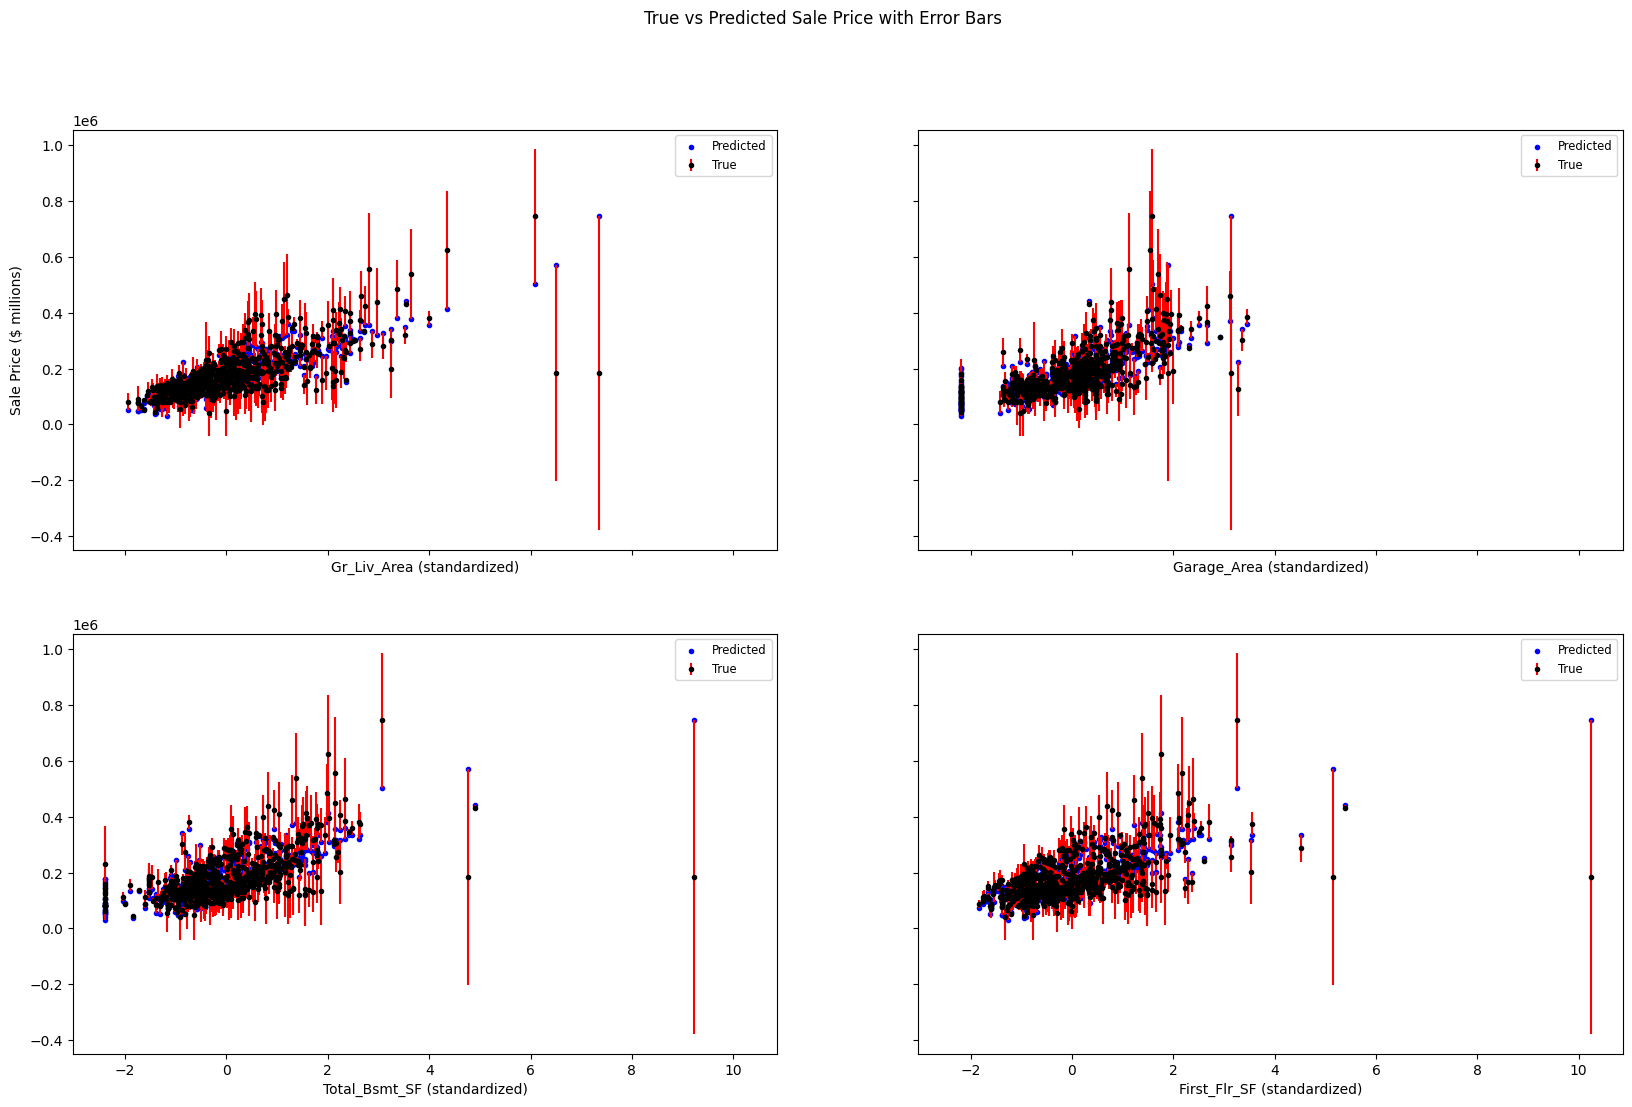

In [18]:
plot_error_bars(ames_df, Y_test, predictions, X_test, top_4_features, 2, 2)

**Summarise findings**

After adding Total_Bsmt_SF and First_Flr_SF to the linear regression model, performance improved slightly. The R² increased from 0.639 to 0.659, and the RMSE as a percentage of the median sale price dropped by 1%, indicating modest gains in explanatory and predictive power.

This limited improvement is likely due to the strong correlation among the square footage features — particularly between Gr_Liv_Area, First_Flr_SF, and Total_Bsmt_SF. Since these features capture overlapping information about the overall size of the home, the new additions contribute relatively little new explanatory value to the model.

## Adding in new features, exploring multicollinearity and the potential for combining data

Using the heat map, it is clear:  
a) Year_built & Year_Remod_Add also have some correlation with sale_price and therefore should be included in some capacity. Max() can be used to define "Year_last_update" which can be a variable to indicate the latest change to the property. Either, the year it was remodelled and if not remodelled the year it was built. Also equations that weights the year towards more recent remodels may also indicate some greater correlation.  
b) Gr_Liv_Area, Total_Bsmt_SF and First_Flr_SF all correlate strongly with each other, so they could be combined into one feature "total_living_SF".

In [19]:
# Combine square footage features into a total
ames_df['Total_SF'] = ames_df['Gr_Liv_Area'] + ames_df['Total_Bsmt_SF'] + ames_df['Second_Flr_SF']

# Exploring creating a single "year" feature

# Max date = remodel, unless no remodel done.
ames_df['Year_last_update'] = ames_df[['Year_Built', 'Year_Remod_Add']].max(axis=1)

# Prioritizes newer builds primarily but recent remodels also.
ames_df['Year_Total'] = (ames_df['Year_Built'] + ames_df['Year_Remod_Add'])

# Weighted date, later remodel are greater than no/old remodels.
ames_df['Modernized_Built'] = ames_df['Year_Built'] * (ames_df['Year_Remod_Add'] / ames_df['Year_Built'])

year_features = ["Year_Built", "Year_last_update", "Year_Total", "Modernized_Built"]

ames_df.sample(n=5)

,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price,Total_SF,Year_last_update,Year_Total,Modernized_Built
2119,1994,1994,1022,1022,0,1022,1,0,3,1,6,0,747,139500,2044,1994,3988,1994.0
445,2003,2004,1760,1760,0,1760,2,0,3,1,8,1,583,269500,3520,2004,4007,2004.0
646,1951,2000,1008,1363,0,1363,1,0,2,1,6,2,288,164900,2371,2000,3951,2000.0
175,1945,1950,747,747,0,747,1,0,2,1,4,0,220,80000,1494,1950,3895,1950.0
2184,1955,1955,0,1152,0,1152,2,0,2,2,6,0,0,61500,1152,1955,3910,1955.0


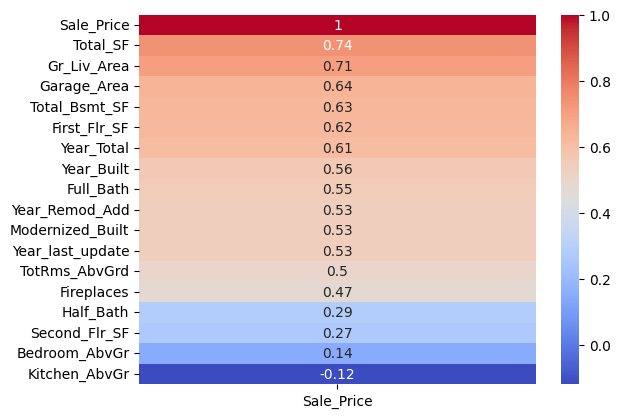

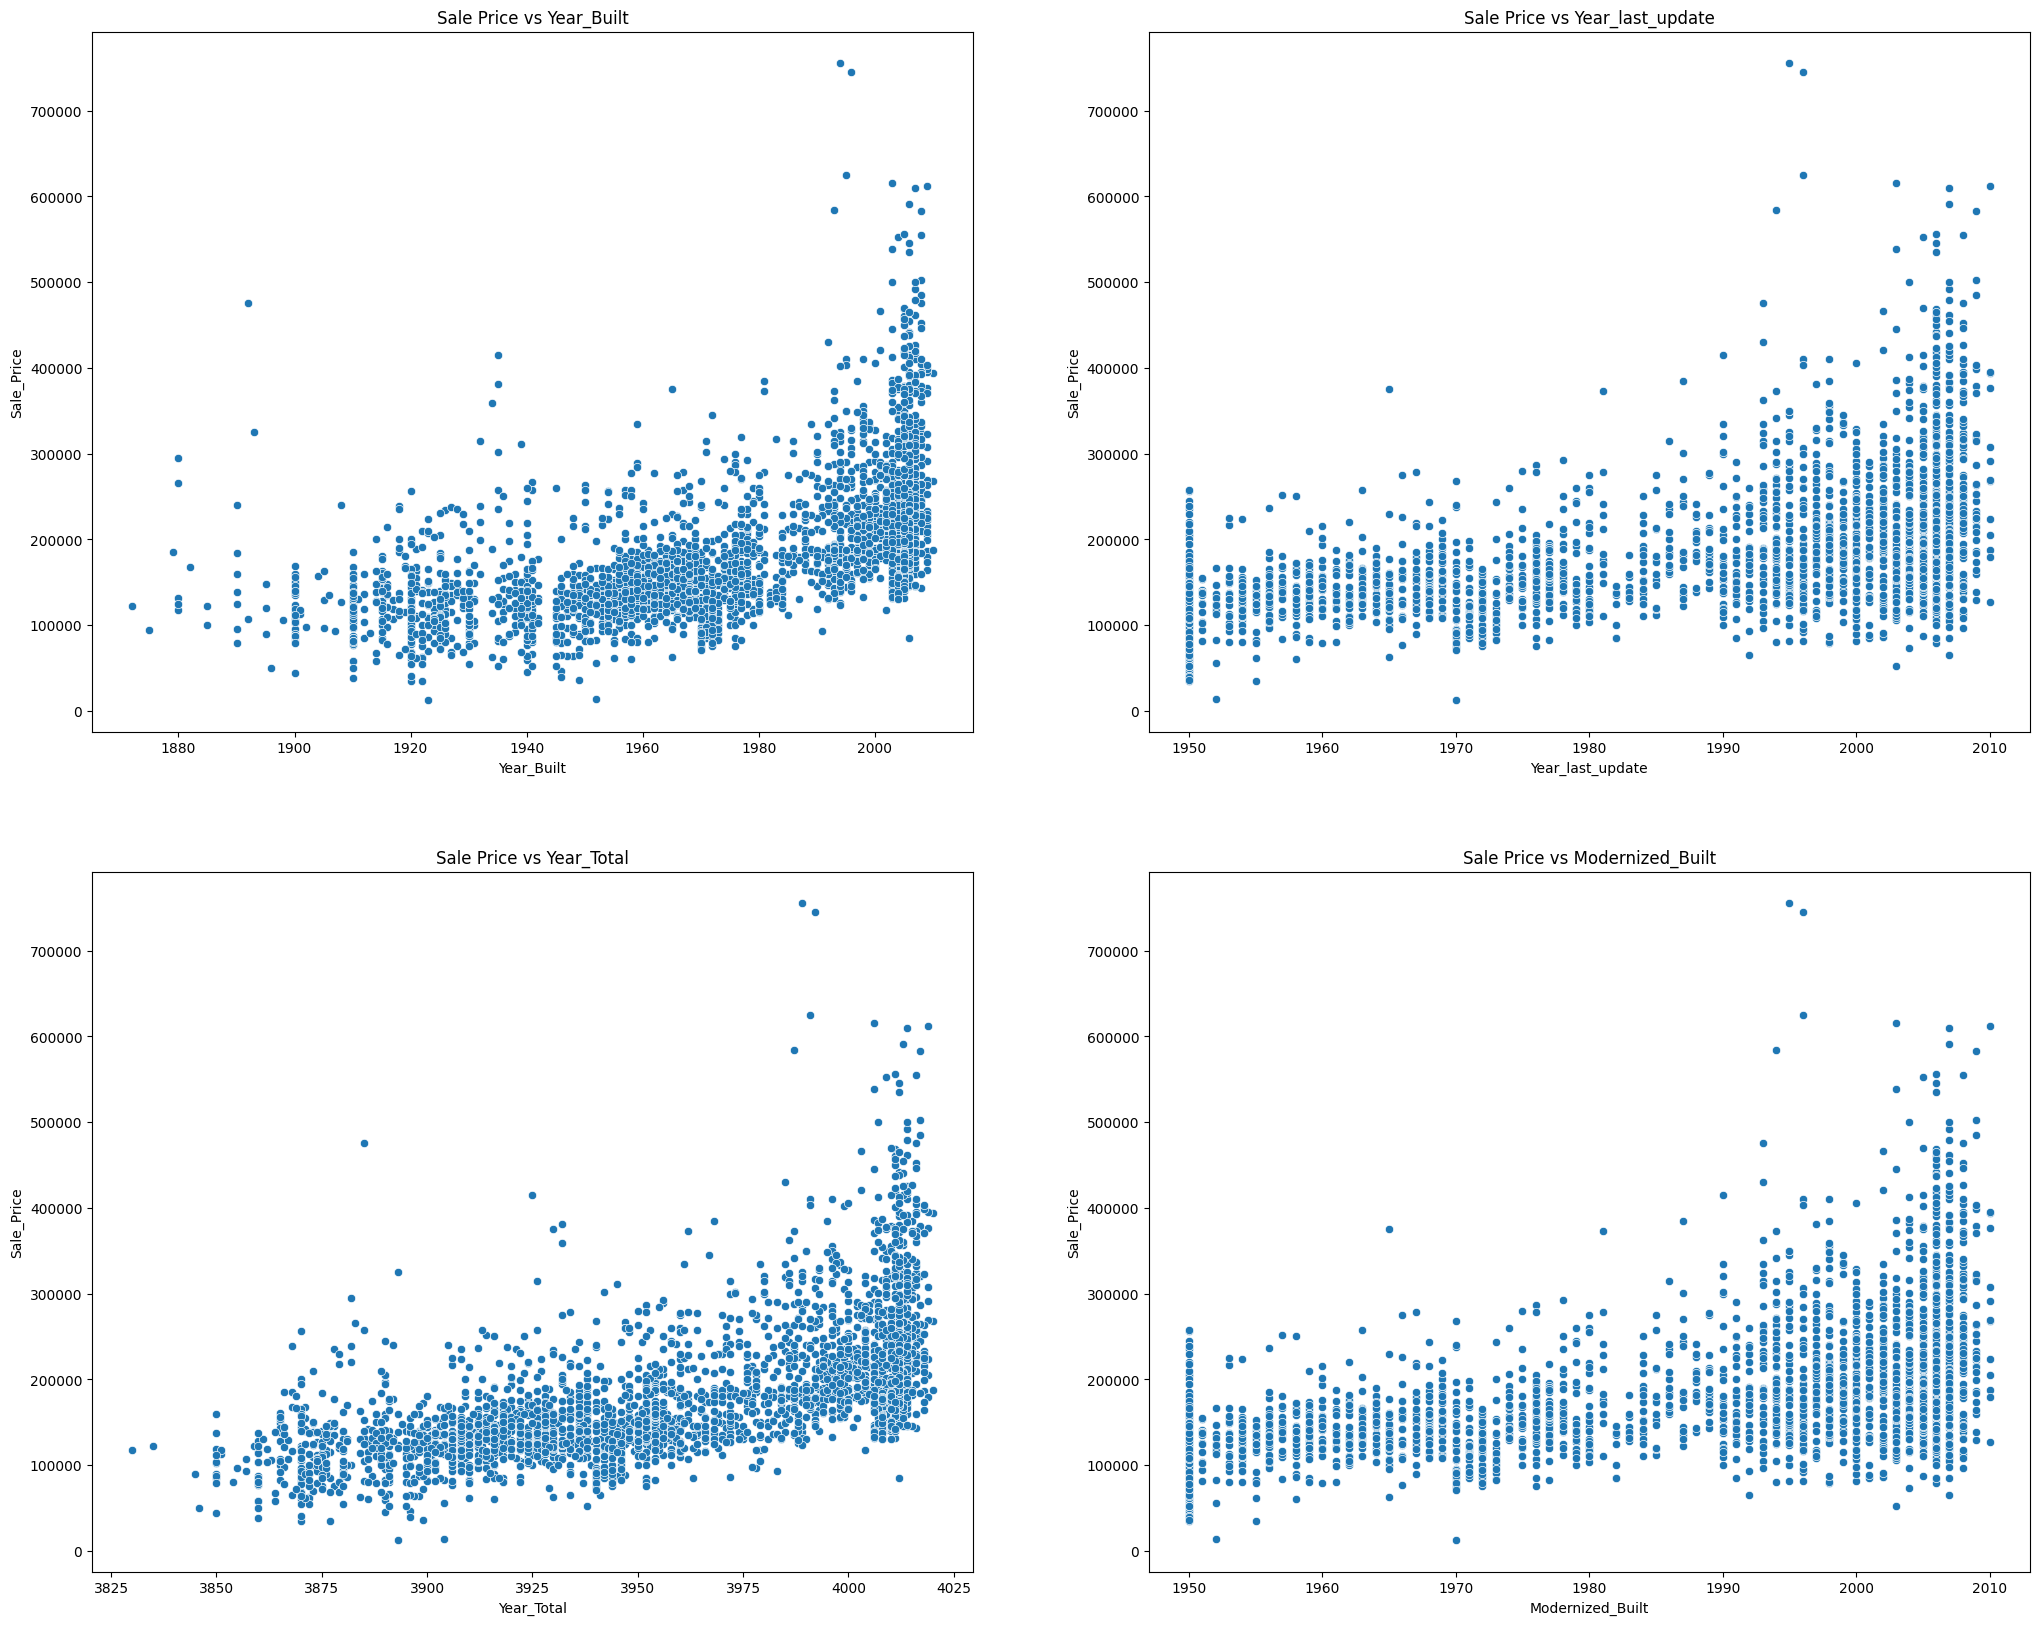

In [20]:
corr_matrix = ames_df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['Sale_Price']].sort_values(by='Sale_Price', ascending=False), annot=True, cmap='coolwarm')

fig, axes = plt.subplots(2, 2, figsize=(25, 20))

for ax, feature in zip(axes.flatten(), year_features):
    sns.scatterplot(x=ames_df[feature], y=ames_df["Sale_Price"], ax=ax)
    ax.set_title(f'Sale Price vs {feature}')
plt.show()

In [21]:
# Year_Total still strongest correlation within "year" features

X = ames_df[['Total_SF', 'Garage_Area', 'Year_Total']]

feature_list = ['Total_SF', 'Garage_Area', 'Year_Total']

X_train, X_test, Y_train, Y_test, sc = training_set(X,Y)


Training data: (2197, 3) (2197, 1)
Test data: (733, 3) (733, 1)


In [22]:
lm, predictions = linear_regression(X_train, X_test, Y_train, feature_list)


Intercept: 
 [180577.2243969]
Coefficients: 
 [[40414.57322549 18406.75466963 25116.96748461]]

This provides a regression equation of: 
Y = 180577.224 + (40414.573 * Total_SF) + (18406.755 * Garage_Area) + (25116.967 * Year_Total)


In [23]:
evaluate_model(Y_test, predictions, feature_list, lm.coef_[0])

Median Sale Price: $162500.00
Mean Sale Price: $181451.97
Mean Squared Error (MSE): 1783818739.72
Root Mean Squared Error (RMSE): $42235.28
RMSE as % of Median Price: 25.99%

Feature coefficient analysis:

Total_SF: 40414.573
A one standard deviation increase in Total_SF leads to an average increase of approximately $40414.57 in predicted sale price.
Given that the median home price is $162500.00, this represents a 24.9% increase relative to a typical home.

Garage_Area: 18406.755
A one standard deviation increase in Garage_Area leads to an average increase of approximately $18406.75 in predicted sale price.
Given that the median home price is $162500.00, this represents a 11.3% increase relative to a typical home.

Year_Total: 25116.967
A one standard deviation increase in Year_Total leads to an average increase of approximately $25116.97 in predicted sale price.
Given that the median home price is $162500.00, this represents a 15.5% increase relative to a typical home.

R² Score: 0.7

0.7263092151047922

In [24]:
make_predictions(lm, sc, X_test, feature_list)


,Total_SF,Garage_Area,Year_Total,Predicted_Sale_Price
0,3740.0,432.0,3882.0,171932.109031
1,1980.0,440.0,3988.0,159243.656241
2,3905.0,753.0,4012.0,277506.527636
3,2144.0,254.0,3962.0,135811.000489
4,2356.0,384.0,3850.0,93826.178763


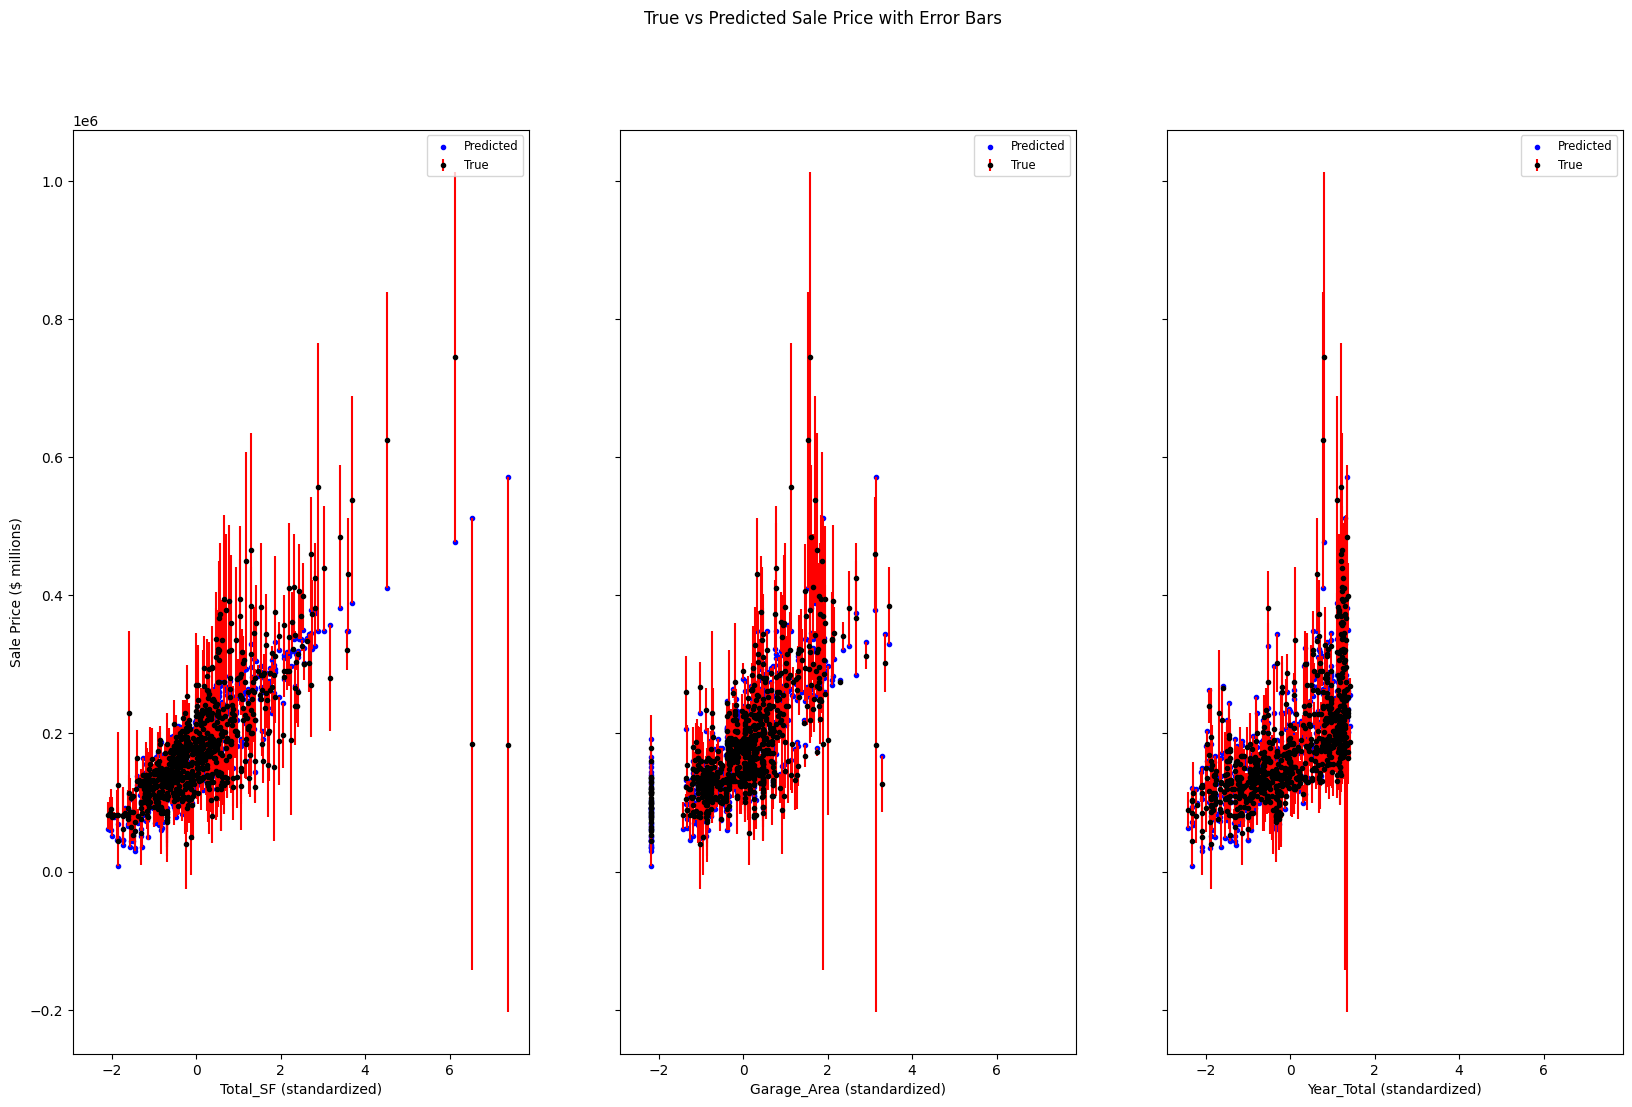

In [25]:
plot_error_bars(ames_df, Y_test, predictions, X_test, feature_list, 1, 3)

**Summarise findings**

Combining highly correlated square footage features into a single Total_SF variable, and including Year_Built, results in a more accurate and interpretable regression model — delivering higher R², lower RMSE, and clearer insights into how home size and age influence sale price.

By consolidating square footage into Total_SF, the model reduces the impact of structural outliers — such as homes with large ground floors but little or no upper floor area — and avoids redundancy among overlapping features. Additionally, Year_Total correlates quite well with sale price, it provides complementary explanatory value that enhances the model’s overall performance and predictive reliability. By summing Year_Built and Year_Remod_Add into a single feature (Year_Total), the model captures both the age of the original construction and the recency of any updates to the property, helping reduce bias where homes built earlier may sell for more than expected due to recent remodels a detail not reflected when using Year_Built alone. The combined feature captures both recent updates and newness, favouring newly built homes slightly more while still accounting for recent remodelling.
| Features Used | R² Score | RMSE     | RMSE (% of Median) |
| ------------- | -------- | -------- | ------------------ |
| 2 (original)  | 0.639    | \$48,487 | 29.8%              |
| 4 (add SF features)  | 0.658    | \$47,201 | 29.0%              |
| Engineered    | 0.715    | \$43,066 | 26.5%              |

There is still a considerable amount of variation unaccounted for, which may be due to factors not present in the dataset, for example, proximity to a train station or town centre, construction materials (such as brick or concrete), or the size and quality of the garden.
